# Sandbox/demo to go along with the MD assignment and lectures

## PharmSci 175/275
Author: David Mobley




## Preparation 

To use this notebook you will either need to run it locally using Jupyter (with a fortran library you pre-compile) or on Google Colab. This notebook briefly explains either route, though if you are going the local route you may need to compile the library before installing some of the other course materials, or do so in a clean/new conda environment. Some users have reported that conda installing `openforcefield`, `openmm` and the openeye toolkits after installing `gfortran` results in the loss of the ability to compile fortran libraries for use in Python.


### Preparation for Google Colab (NOT FOR LOCAL USE)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/MD/MD_Sandbox.ipynb)

**For Google Colab, install mamba and gfortran as in the `Getting_Started.ipynb` in the intro course materials (insert that code below):**

Next, mount your Google Drive and ensure you have the md_sandbox.f90 file available **at a path you define below**:

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

#EDIT THIS TO DEFINE WHERE YOU PUT THE FILE:
md_library_path = '/content/drive/MyDrive/drug-computing/uci-pharmsci/lectures/MD/'

# Then run:
%cd $md_library_path

Then compile the requisite library:

In [1]:
!f2py -c -m md_sandbox md_sandbox.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "md_sandbox" sources
f2py options: []
f2py:> /var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/src.macosx-10.9-x86_64-3.8/md_sandboxmodule.c
creating /var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/src.macosx-10.9-x86_64-3.8
Reading fortran codes...
	Reading file 'md_sandbox.f90' (format:free)
Post-processing...
	Block: md_sandbox
			Block: calcenergy
			Block: calcenergyforces
			Block: vvintegrate
Post-processing (stage 2)...
Building modules...
	Building module "md_sandbox"...
		Constructing wrapper function "calcenergy"...
		  penergy = calcenergy(pos,m,l,rc,[dim,natom])
		Constructing wrapper function "calcenergyforces"...
		  penergy,forces = calcenergyforces(pos,m,l,rc,forces,[dim,natom])
		Con

/usr/local/bin/gfortran -Wall -g -arch x86_64 -Wall -g -undefined dynamic_lookup -bundle /var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/src.macosx-10.9-x86_64-3.8/md_sandboxmodule.o /var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/src.macosx-10.9-x86_64-3.8/fortranobject.o /var/folders/7z/88tvgj2941bclbbw1xhn0t8r0000gn/T/tmpm7bkjeb3/md_sandbox.o -L/usr/local/lib/gcc/x86_64-apple-darwin19/11.2.0 -L/usr/local/lib/gcc/x86_64-apple-darwin19/11.2.0/../../.. -L/usr/local/lib/gcc/x86_64-apple-darwin19/11.2.0/../../.. -lgfortran -o ./md_sandbox.cpython-38-darwin.so
ld: warning: dylib (/usr/local/lib/libgfortran.dylib) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/usr/local/lib/libquadmath.dylib) was built for newer macOS version (11.0) than being linked (10.9)
Removing build directory /var/folders/7z/88tvgj294

### Preparation for local use

For local use, you need to compile the fortran module `md_sandbox` for use as a Python library. This accelerates the numerical calculations and a similar framework will be used in the MD and MC assignments. Use `f2py3 -c -m md_sandbox md_sandbox.f90` to compile. (As noted above you may need to do this in advance of installing certain modules, such as the beginning of the course, or by making a clean conda environment.)

## MD for a simple Lennard-Jones system

### Here, let's play with a very simple model system
In the MD assignment, we will be looking at a very simple polymer model. But here, let's backtrack to simple Lennard-Jones spheres (as used in the energy minimization assignment) and look at what happens if we run a simple dynamics calculation on a couple of particles subject to this potential, which will allow us to get a feel for how the integrator works.

Remember, for a Lennard-Jones system, the dimensionless form of our potential is 
\begin{equation}
U^* = \sum \limits_{i} 4\left( r_{ij}^{-12} - r_{ij}^{-6}\right) 
\end{equation}

which we can easily graph to get a sense of what will happen.

### We graph the potential for a pair of particles:

## Now, let's run some dynamics on a pair of particles subject to this potential


Here I've written a modified `mdlib.f90` (updated from that from the energy minimization and MD assignments) called `md_sandbox.f90`. Compile it as usual (with `f2py`) into `md_sandbox` (e.g. `f2py -c -m md_sandbox md_sandbox.f90` or similar) so that you can import it below. 

The difference between this and `mdlib` that you will use in your MD assignment is that I've removed the bonds between atoms, so that we have simple Lennard-Jones particles rather than LJ polymers.

### First, we set up our system:

In [1]:
#Get pylab ready for plotting in this notebook - "magic" command specific for iPython notebooks
%pylab inline
#Import numpy
import numpy as np

#Generate array of distances to graph at
r = np.arange( 0,3, 0.01)

#Calculate U
U = 4.*(r**(-12.) - r**(-6.))

#Graph
plot( r, U, 'b-')
#Label x and y axes
xlabel('r')
ylabel('U')
#Adjust y limits not to be auto-scaled; since this goes to infinity at zero, the graph will not be useful unless we truncate
ylim(-2,2)


In [2]:
import md_sandbox
from md_sandbox import *

#Let's define the variables we'll need
dt = 0.001
Cut = 2.5
L = 10 #Let's just put these in a fairly big box so we have room
M = 1 #Here this doesn't actually do anything, but I didn't remove it from the functions


#Choose N for number of particles
N = 2

#Allocate position array - initially just zeros
Pos = np.zeros((N,3), float)

#In this case, place two LJ particles at specified initial positions - chosen so they are relatively near each other
#If you had more than two particles you'd need to adjust this
Pos[0,:] = np.array([0,0,0])
Pos[1,:] = np.array([1.2,0,0])
#Might be worth experimenting to see what happens if we randomly place the particles instead


#Assign initial velocities - in this case I'll start off with them stationary and see what happens
Vel = np.array([[0,0,0],[0,0,0]], float)
#You could tweak the initial velocities to see what happens under different conditions

## Before we do any dynamics, notice that this is really a 1D system, so let's write a function to compute r, which we will store later

In [3]:
def get_r(Pos):
    """Calculate r, the distance between particles, for a position array containing just two particles. Return it."""
    
    #Get displacement
    dist = Pos[1,:] - Pos[0,:]
    #Calculate distance and return
    return np.sqrt( np.dot( dist, dist))

## OK, now let's start doing some dynamics

We're going to want to store the distance between the two particles as a function of time, so we can graph it. We also might want to look at the population of each distance as a function of time and see how that compares with the energy landscape. Though, right now that's a little premature. Let's just start off by taking a few timesteps and see how the distance changes. 

In [4]:
#Define storage for positions at each time so we can track them
max_steps = 5000 #Maximum number of steps we will take - so we know how many positions we might store
Pos_t = np.zeros(( N,3,max_steps), float)

#Store initial positions
Pos_t[:,:,0] = Pos

#Make up initial forces
Forces = np.zeros((N,3), float)

#Kick things off by calculating energy and forces
energy, Forces = calcenergyforces( Pos, M, L, Cut, Forces )

#Take a timestep
Pos, Vel, Accel, KEnergy, PEnergy = vvintegrate( Pos, Vel, Forces, M, L, Cut, dt )

#Store new positions
Pos_t[:,:,1] = Pos

#Print original and current distance
for i in range(0,2):
    print(get_r(Pos_t[:,:,i]))

## What should the long-time behavior of this system be?

Before going on to the step below, think for a minute about what motion these particles should exhibit on long timescales and what it would look like if you've graphed it.

Once you've done so, write a `for` loop to run over max_steps and at each step, update the energy and forces, take a timestep, and store the new positions.

In [5]:
for i in range(max_steps):
    #Your code goes here
    


## Once you've done that, use this code to graph r versus time for your particles

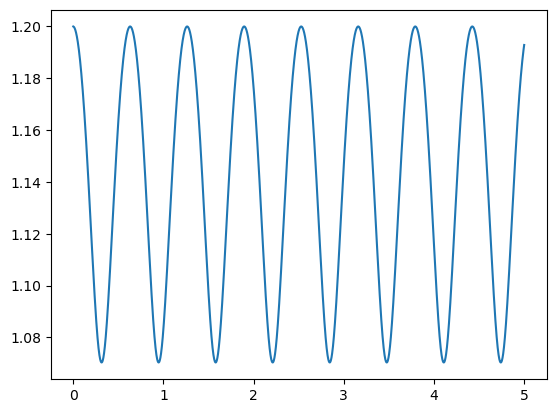

In [6]:
#Find x axis (time values)
t = dt*np.arange(0,max_steps)
#Find y axis (r values)
r_vs_t = []
for i in range(max_steps):
    r=get_r(Pos_t[:,:,i])
    r_vs_t.append(r)

r_vs_t = np.array(r_vs_t)

    
#Plot
figure()
plot(t, r_vs_t)
    

## Additional exercises

Some things you might want to try on the above 1D system:
- Change the amount of time the data is graphed for; see if you can make it oscillate repeatedly
- Consider how you could adjust the total energy of the system
- What if you change the total energy (increasing it or reducing it). Can you make it look more like a harmonic oscillator? Less like a harmonic oscillator? Why or why not?
- Can you find solutions which are not oscillatory? How? 
- For the ambitious: Consider extending this example to three or more particles and graph just some of the distances involved. What kind of solutions can you find?